# Anime Dataset 2023

Dataset Kaggle : https://www.kaggle.com/datasets/dbdmobile/myanimelist-dataset
- anime-dataset-2023.csv
- user-filtered.csv

The Goal of this project is to recommand anime for a specific user considering his anime list.

In [1]:
from cornac.models import ItemKNN, UserKNN

import scipy.sparse as sparse
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

/home/wyvern/.local/share/virtualenvs/PROJET-NeHBW21p/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMPORT_PATH_BASE = "datasets/"

## Loading the datasets

In [3]:
# Read the anime dataset
anime_df = pd.read_csv(IMPORT_PATH_BASE + 'anime-dataset-2023.csv')

# Read the user dataset
user_df = pd.read_csv(IMPORT_PATH_BASE + 'user-filtered.csv')

In [4]:
anime_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Type', 'Episodes', 'Aired', 'Premiered', 'Status',
       'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating',
       'Rank', 'Popularity', 'Favorites', 'Scored By', 'Members', 'Image URL'],
      dtype='object')

## Filtering the data

In [5]:
anime_df.drop(columns=['Other name', 'Name', 'Synopsis', 'Source', 'Premiered', 'Status', 'Producers', 'Licensors', 'Duration'], inplace=True)
anime_df.rename(columns={'English name': 'Name'}, inplace=True)
anime_df = anime_df.drop(anime_df[anime_df.eq('UNKNOWN').any(axis=1)].index)
anime_df = anime_df[anime_df['Type'].isin(['Movie', 'TV', 'TV Short'])]
user_df = user_df[user_df['anime_id'].isin(anime_df['anime_id'])]
anime_df = anime_df[anime_df['anime_id'].isin(user_df['anime_id'])]


In [6]:
anime_df

,anime_id,Name,Score,Genres,Type,Episodes,Aired,Studios,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Sunrise,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: The Movie,8.38,"Action, Sci-Fi",Movie,1.0,"Sep 1, 2001",Bones,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,8.22,"Action, Adventure, Sci-Fi",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Madhouse,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,7.25,"Action, Drama, Mystery, Supernatural",TV,26.0,"Jul 3, 2002 to Dec 25, 2002",Sunrise,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Beet the Vandel Buster,6.94,"Adventure, Fantasy, Supernatural",TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Toei Animation,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20915,48470,D_Cide Traumerei the Animation,5.81,"Action, Drama, Fantasy",TV,13.0,"Jul 10, 2021 to Oct 2, 2021",SANZIGEN,PG-13 - Teens 13 or older,9647.0,4243,102,6258.0,23808,https://cdn.myanimelist.net/images/anime/1635/...
20916,48471,Irina: The Vampire Cosmonaut,7.31,"Fantasy, Sci-Fi",TV,12.0,"Oct 4, 2021 to Dec 20, 2021",Arvo Animation,PG-13 - Teens 13 or older,2459.0,1499,689,49075.0,140342,https://cdn.myanimelist.net/images/anime/1393/...
20921,48488,Higurashi: When They Cry – SOTSU,6.73,"Avant Garde, Horror, Mystery, Supernatural, Su...",TV,15.0,"Jul 1, 2021 to Sep 30, 2021",Passione,R - 17+ (violence & profanity),5201.0,1882,722,41407.0,104539,https://cdn.myanimelist.net/images/anime/1083/...
20922,48491,Encouragement of Climb: Next Summit,7.63,"Adventure, Slice of Life",TV,12.0,"Oct 5, 2022 to Dec 21, 2022",8bit,PG-13 - Teens 13 or older,1307.0,4347,90,5556.0,22465,https://cdn.myanimelist.net/images/anime/1942/...


In [7]:
user_df

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
5,0,24,9
...,...,...,...
109224741,353404,243,7
109224743,353404,392,9
109224744,353404,882,6
109224745,353404,883,8


In [8]:
user_df = user_df[user_df['rating'] != 0]
user_counts = user_df['user_id'].value_counts()

In [9]:
filtered_users_400 = user_counts[(user_counts > 400) & (user_counts <= 600)].index
sampled_users_400 = filtered_users_400.to_series().sample(n=150, random_state=42)
result_df_400 = user_df[user_df['user_id'].isin(sampled_users_400)]
result_df_400

,user_id,anime_id,rating
153808,516,40392,8
153809,516,39575,7
153810,516,41380,8
153811,516,36793,5
153812,516,38101,6
...,...,...,...
108160449,349955,15119,6
108160451,349955,40902,5
108160452,349955,3588,8
108160453,349955,849,8


In [10]:
filtered_users_100_200 = user_counts[user_counts.between(100, 200)].index
sampled_users_100_200 = filtered_users_100_200.to_series().sample(n=400, random_state=42)
result_df_100_200 = user_df[user_df['user_id'].isin(sampled_users_100_200)]
result_df_100_200

,user_id,anime_id,rating
226051,757,12291,10
226052,757,15085,8
226053,757,1689,8
226054,757,23333,7
226056,757,12189,9
...,...,...,...
108544892,351152,1726,7
108544893,351152,249,7
108544894,351152,33489,5
108544895,351152,1254,8


In [11]:
filtered_users_50_100 = user_counts[user_counts.between(50, 100)].index
sampled_users_50_100 = filtered_users_50_100.to_series().sample(n=500, random_state=42)
result_df_50_100 = user_df[user_df['user_id'].isin(sampled_users_50_100)]
result_df_50_100

,user_id,anime_id,rating
221116,739,18671,10
221121,739,457,7
221122,739,16067,7
221124,739,205,8
221129,739,47,9
...,...,...,...
109178967,353272,37976,6
109178982,353272,6500,7
109178983,353272,4063,6
109178987,353272,36882,2


In [12]:
final_result_df = pd.concat([result_df_400, result_df_100_200, result_df_50_100]).reset_index(drop=True)
final_result_df

,user_id,anime_id,rating
0,516,40392,8
1,516,39575,7
2,516,41380,8
3,516,36793,5
4,516,38101,6
...,...,...,...
166755,353272,37976,6
166756,353272,6500,7
166757,353272,4063,6
166758,353272,36882,2


# Data evaluation and recommendation

In [13]:
def split_data(data, split_percentage):
    train_set = data[0:int(split_percentage * data.shape[0])]
    test_set = data[int(split_percentage * data.shape[0]):]
    
    rating = list(train_set.rating)

    users = data['user_id'].unique()
    items = data['anime_id'].unique()

    rows = train_set.user_id.astype(pd.api.types.CategoricalDtype(categories = users)).cat.codes
    cols = train_set.anime_id.astype(pd.api.types.CategoricalDtype(categories = items)).cat.codes

    rating_matrix = sparse.csr_matrix((rating, (rows, cols)), shape = (len(users), len(items)))

    return rating_matrix, train_set, test_set
    
def plot_similarity_matrix(similarity_matrix, similarity_metric, base):
    plt.figure()
    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.title(f"{base}-{base} {similarity_metric} Similarity Matrix")
    plt.colorbar()

In [14]:
final_result_df['rating'].value_counts()

rating
8     44616
7     36644
9     31926
10    20893
6     16629
5      8393
4      3990
3      1885
2       976
1       808
Name: count, dtype: int64

In [15]:
user_id = 10
k_values = [5, 10, 15, 30, 50, 100]
threshold = 3.5
top_n = 10

split_percentage = 0.9              # 90% of the data will be used for training and 10% for testing
core = 1000                         # keep only items that where rated by at least $core$ users

In [16]:
rating_matrix, train, test = split_data(final_result_df, split_percentage)

## 3.2 Item-based Collaborative Filtering

In [17]:
from cornac.data.dataset import Dataset

In [18]:
interactions = final_result_df[['user_id', 'anime_id', 'rating']].values.tolist()

dataset = Dataset.from_uir(interactions, seed=42)

### • Item Similarity Computation

In [19]:
itemcf=ItemKNN(k=10)
itemcf.fit(dataset)

100%|██████████| 3119/3119 [00:00<00:00, 21649.82it/s]


### • Neighborhood Formation

TypeError: Image data of dtype object cannot be converted to float

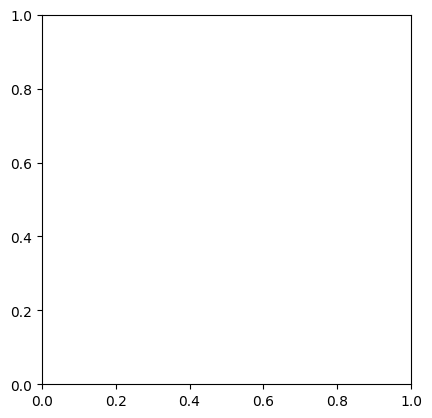

In [20]:
# plot_similarity_matrix(itemcf.sim_mat, 'cosine', 'Item')

### • Recommendation Generation

In [23]:
itemcf.score(1)

AttributeError: 'csr_matrix' object has no attribute 'A'

## 3.3 User-based Collaborative Filtering

### • Item Similarity Computation

In [ ]:
usercf=ItemKNN(k=10)
usercf.fit(train)

AttributeError: 'DataFrame' object has no attribute 'reset'

### • Neighborhood Formation

In [ ]:
plot_similarity_matrix(usercf.sim_mat, 'cosine', 'User')

### • Recommendation Generation

In [ ]:
usercf.predict(user_id, top_n)